In [1]:
import numpy as np
import pandas as pd

In [4]:
def generate_rdd_data(n=500, cutoff=50, random_seed=42):
    np.random.seed(random_seed)
    
    # Running variable (test score) from 0 to 100
    score = np.random.uniform(0, 100, size=n)
    
    # Treatment indicator if score >= cutoff
    treatment = (score >= cutoff).astype(int)
    
    # Baseline outcome
    outcome_base = 30 + 0.5 * score  # linear relationship with score
    
    # Jump in outcome at cutoff
    # Let's assume a jump of +10 if above cutoff
    outcome = outcome_base + treatment * 10
    
    # Add random noise
    outcome += np.random.normal(0, 10, size=n)
    
    df_rdd = pd.DataFrame({
        'score': score,
        'treatment': treatment,
        'outcome': outcome
    })
    
    return df_rdd

# Example usage:
df_rdd = generate_rdd_data()
df_rdd.head(15)

,score,treatment,outcome
0,37.454012,0,52.144566
1,95.071431,1,106.297424
2,73.199394,1,86.103935
3,59.865848,1,64.163888
4,15.601864,0,28.816785
5,15.599452,0,42.718918
6,5.808361,0,19.701849
7,86.617615,1,101.623395
8,60.111501,1,81.850152
9,70.807258,1,70.711872


<Axes: xlabel='score', ylabel='outcome'>

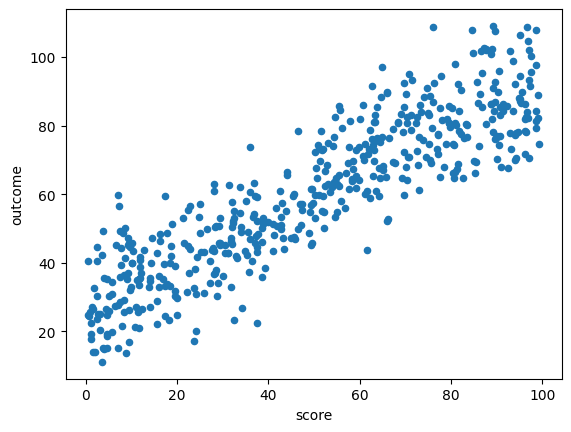

In [5]:
# Plot the outcome vs. the score. Look for a discontinuity around the threshold of 50.
df_rdd.plot(x='score', y='outcome', kind='scatter')

In [6]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

def rdd_analysis(df, cutoff=None, bandwidth=None, outcome_var='outcome', running_var='score'):
    """
    Perform Regression Discontinuity Design (RDD) analysis
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    cutoff : float, optional
        The RDD cutoff point. If None, uses median
    bandwidth : float, optional
        The bandwidth around cutoff. If None, uses IQR/2
    outcome_var : str
        Name of the outcome variable
    running_var : str
        Name of the running/assignment variable
    
    Returns:
    --------
    dict with regression results and treatment effect
    """
    # Set default cutoff and bandwidth if not provided
    if cutoff is None:
        cutoff = df[running_var].median()
    if bandwidth is None:
        bandwidth = df[running_var].quantile(0.75) - df[running_var].quantile(0.25)
        bandwidth = bandwidth / 2

    # Create treatment indicator
    df['treated'] = (df[running_var] >= cutoff).astype(int)
    
    # Center the running variable at cutoff
    df['centered_score'] = df[running_var] - cutoff
    
    # Select data within bandwidth
    mask = (df[running_var] >= cutoff - bandwidth) & (df[running_var] <= cutoff + bandwidth)
    df_window = df[mask].copy()
    
    # Create interaction term
    df_window['interaction'] = df_window['centered_score'] * df_window['treated']
    
    # Prepare data for statsmodels
    X = sm.add_constant(df_window[['centered_score', 'treated', 'interaction']])
    y = df_window[outcome_var]
    
    # Fit the model
    model = sm.OLS(y, X).fit(cov_type='HC1')  # Using robust standard errors
    
    # Calculate treatment effect at cutoff
    treatment_effect = model.params['treated']
    
    # Prepare results
    results = {
        'model': model,
        'treatment_effect': treatment_effect,
        'p_value': model.pvalues['treated'],
        'confidence_interval': (
            model.conf_int().loc['treated', 0],
            model.conf_int().loc['treated', 1]
        ),
        'bandwidth': bandwidth,
        'cutoff': cutoff,
        'n_observations': len(df_window)
    }
    
    return results

In [7]:
# Example usage:
# Run the analysis
results = rdd_analysis(df_rdd, cutoff=50, bandwidth=10)

# Print results
print(f"RDD Analysis Results:")
print(f"Treatment Effect: {results['treatment_effect']:.4f}")
print(f"P-value: {results['p_value']:.4f}")
print(f"95% CI: [{results['confidence_interval'][0]:.4f}, {results['confidence_interval'][1]:.4f}]")
print(f"Number of observations: {results['n_observations']}")
print("\nFull Model Summary:")
print(results['model'].summary())

RDD Analysis Results:
Treatment Effect: 8.9525
P-value: 0.0033
95% CI: [2.9878, 14.9171]
Number of observations: 86

Full Model Summary:
                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     19.60
Date:                Fri, 24 Jan 2025   Prob (F-statistic):           1.13e-09
Time:                        19:49:15   Log-Likelihood:                -300.05
No. Observations:                  86   AIC:                             608.1
Df Residuals:                      82   BIC:                             617.9
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025   